In [21]:
%matplotlib inline  

import matplotlib.pyplot as plt
from pylabnet.utils.logging.logger import LogClient
from zi_hdawg import Driver, Sequence, AWGModule

from zi_hdawg import DIOPulseBlockHandler
import pylabnet.utils.pulseblock.pulse as po
import pylabnet.utils.pulseblock.pulse_block as pb
import numpy as np
from pylabnet.utils.pulseblock.pb_iplot import iplot
from pylabnet.utils.pulseblock.pb_sample import pb_sample

In [85]:
dev_id = 'dev8040'
from pylabnet.utils.logging.logger import LogClient

# Instantiate
logger = LogClient(
    host='192.168.1.2',
    port=3698,
    module_tag=f'ZI HDAWG {dev_id}'
)

hd = Driver(dev_id, logger=logger)

In [112]:

def rabi_element(tau=0, aom_offset=0):
    rabi_element = pb.PulseBlock(
        p_obj_list=[
            po.PTrue(ch='aom', dur=1.1e-6),
            po.PTrue(ch='ctr', t0=0.5e-6, dur=0.5e-6)
        ]
    )
    temp_t = rabi_element.dur

    rabi_element.insert(
        p_obj=po.PTrue(ch='mw_gate', dur=tau, t0=temp_t+0.7e-6)
    )
    temp_t = rabi_element.dur

    rabi_element.insert(
        p_obj=po.PTrue(ch='aom', t0=temp_t+aom_offset, dur=2e-6)
    )
    rabi_element.insert(
        p_obj=po.PTrue(ch='ctr', t0=temp_t, dur=0.5e-6)
    )

    rabi_element.dflt_dict = dict(
        aom=po.DFalse(),
        ctr=po.DFalse(),
        mw_gate=po.DFalse()
    )

    return rabi_element

In [ ]:
len_samples = 10
sampling_rate = 300e6
on_pulse = pb.PulseBlock(
            p_obj_list=[
                po.PFalse(ch='aom',  dur=len_samples/sampling_rate)]
)


on_pulse.append(
            p_obj=po.PTrue(ch='aom',  dur=len_samples/sampling_rate)
        )

on_pulse.append(
            p_obj=po.PFalse(ch='aom',  dur=len_samples/sampling_rate)
        )

on_pulse.dflt_dict = dict(
            aom=po.DFalse(),
        )


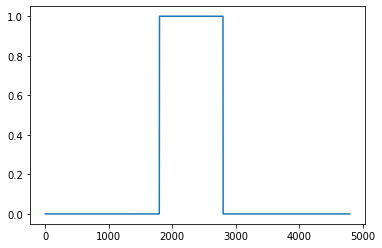

In [124]:


on_pulse = rabi_element(1000e-9)
iplot(on_pulse)



sampled_pb = pb_sample(on_pulse, samp_rate=sampling_rate)
times = np.arange(len(sampled_pb[0]['mw_gate']))/sampling_rate
plt.plot(times*1e9, sampled_pb[0]['mw_gate'])

In [93]:
len_samples/sampling_rate

3.3333333333333334e-08

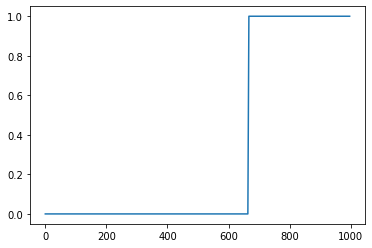

In [73]:
times = np.arange(len(sampled_pb[0]['aom']))/sampling_rate
plt.plot(times*1e9, sampled_pb[0]['aom'])

In [116]:
as_dict = {
    'mw_gate':   15,
    'ctr':      17,
    'aom':      31,

}

In [117]:
pb_handler = DIOPulseBlockHandler(on_pulse, as_dict, hd=hd)
pb_handler.setup_hd()
pb_handler.gen_codewords()
dig_pulse_sequence = pb_handler.zip_dio_commands()

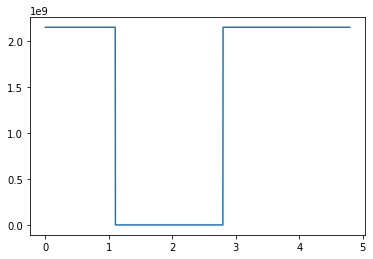

In [118]:
times = np.arange(len(pb_handler.dio_codewords))/sampling_rate
plt.plot(times*1e6, pb_handler.dio_codewords)

In [119]:
# Select channel grouping
hd.set_channel_grouping(0)


outputs = [0]

# Enable the outputs and set corresponding ranges
hd.enable_output(outputs)

In [120]:
sequence_txt = """\

        while (1) {

          // Trigger to scope.
          setTrigger(1);
          
          _dig_pulse_


          // Wait
          wait(1000);


          setTrigger(0);

        }
        """

# Create Sequence Object and replace placeholder
seq = Sequence(hd, sequence_txt, ['dig_pulse'])
seq.replace_placeholder('dig_pulse', dig_pulse_sequence)

In [121]:
# Create an instance of the AWG Module
awg = AWGModule(hd, 0)
awg.set_sampling_rate('2.4 GHz') # Set 2.4 GHz sampling rate

# Upload sequence
if awg is not None:
    awg.compile_upload_sequence(seq)

In [123]:
# Start the AWG
awg.start()